In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [5]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'term', 'originated', 'anarchism', 'of', 'term', 'originated', 'as']


Train a skip-gram model.

In [7]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [8]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.080782
Nearest to up: jima, monomers, anglophones, gamespot, percussive, pseudolus, bader, fujimori,
Nearest to or: aeronautical, nast, awa, baez, verdi, accomplice, arteries, ac,
Nearest to for: mil, dortmund, listened, pld, montag, drank, frasier, forefront,
Nearest to history: mille, tin, mick, eldorado, artisan, discontinuities, chronicler, orfeo,
Nearest to and: visionary, indeterminate, brin, judgments, perpetual, isometry, lengthening, fielders,
Nearest to four: hostages, dov, normalized, aleksei, royalists, circumflex, fezzan, scuderia,
Nearest to such: gatekeeper, tero, countrymen, angelico, japheth, shevardnadze, cutlery, apportioned,
Nearest to use: noriega, angli, laguna, hp, impressive, emanating, bde, benzodiazepines,
Nearest to while: domesday, coordination, resolutely, investors, prompts, breakdowns, perfection, provinces,
Nearest to all: embassies, extremist, amputation, discussing, corresponding, conflicts, wang, aristocrats,
Near

Nearest to the: its, their, a, this, his, some, oysters, our,
Average loss at step 52000: 3.437109
Average loss at step 54000: 3.427349
Average loss at step 56000: 3.440441
Average loss at step 58000: 3.393671
Average loss at step 60000: 3.394233
Nearest to up: out, them, off, him, down, back, gamespot, hotly,
Nearest to or: and, than, osmosis, subsistence, mirabilis, rouge, topological, but,
Nearest to for: without, of, when, including, wording, listened, repudiate, if,
Nearest to history: list, geography, retract, democratic, syndication, mobile, pallium, demographics,
Nearest to and: or, but, although, privy, than, including, imparted, salt,
Nearest to four: six, five, eight, three, seven, nine, two, zero,
Nearest to such: well, these, known, many, jansen, chondrites, follows, regarded,
Nearest to use: cristobal, end, happiest, disbanded, mifune, fughetta, ejected, application,
Nearest to while: when, although, after, tubulin, before, incited, including, opiates,
Nearest to all: bot

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

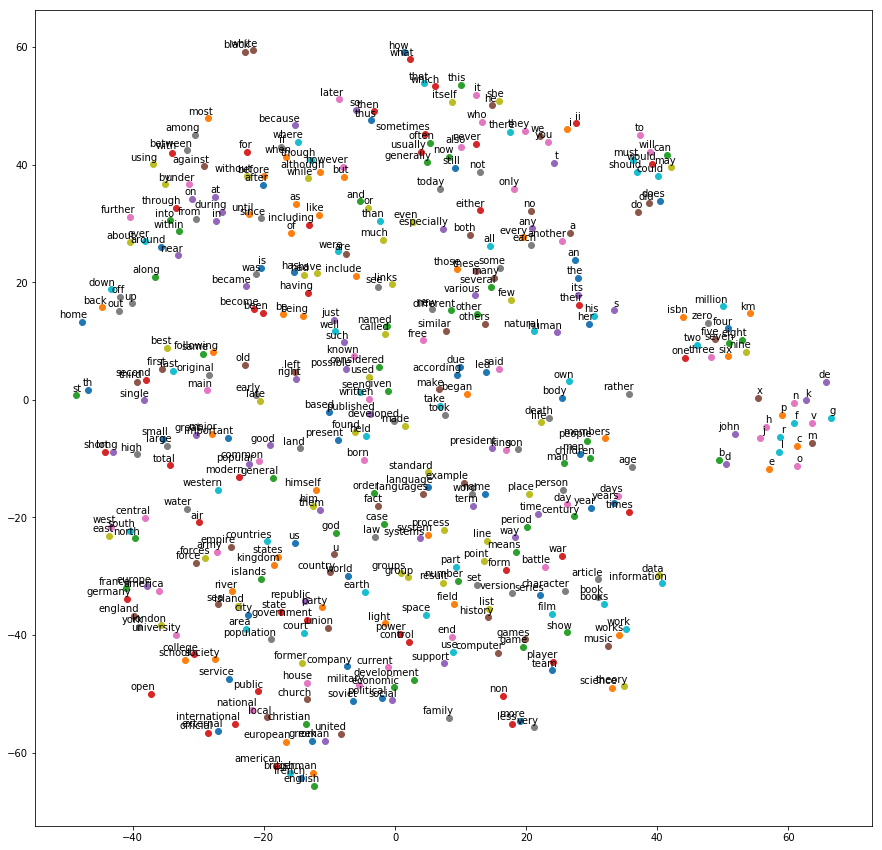

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

Continous bag of words

In [45]:
data_index = 0

def generate_batch_cbow(batch_size, skip_window):
  global data_index
  context_window = 2*skip_window
  #assert batch_size % num_skips == 0
  assert batch_size % context_window == 0 #Does the context window fit in the batch
  #assert num_skips <= 2 * skip_window
  num_labels = batch_size // context_window # the number of labels is the how many context windows fit in the batch
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(num_labels):
    target = skip_window  # target label at the center of the buffer
    labels[i, 0] = buffer[target] # set he label
    targets_to_avoid = [ skip_window ]
    for j in range(context_window):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * context_window + j] = buffer[target]
      #labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

skip_window = 1
#batch, labels = generate_batch_cbow(8, skip_window)
#print (np.shape(labels))
#for i in range(8):
#  print (batch[i], '->', labels[i/(2*skip_window), 0])
#  print (reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i/(2*skip_window), 0]])
#del skip_window # remove skip_window setting used for testing
   
batch, labels = generate_batch_cbow(batch_size=8, skip_window=skip_window)
for i in range(8):
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
    batch: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of']
    labels: ['originated', 'as', 'a', 'term', 'term', 'as', 'of', 'a']
    batch: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of']
    labels: ['originated', 'as', 'a', 'term', 'term', 'as', 'of', 'a']
    batch: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of']
    labels: ['originated', 'as', 'a', 'term', 'term', 'as', 'of', 'a']
    batch: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of']
    labels: ['originated', 'as', 'a', 'term', 'term', 'as', 'of', 'a']
    batch: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of']
    labels: ['originated', 'as', 'a', 'term', 'term', 'as', 'of', 'a']
    batch: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of']
    labels: ['originated', 'as', 'a', 'term', 'term', 'as', 'of', 'a']
    batch: ['anarchism', 'as', 'originated', 'a

Train CBOW model

In [66]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)

  # seq_ids only needs to be generated once so do this as a numpy array rather than a tensor.
  seq_ids = np.zeros(batch_size, dtype=np.int32)
  cur_id = -1
  for i in range(batch_size):
    if i % context_window == 0:
      cur_id = cur_id + 1
    seq_ids[i] = cur_id
  print (seq_ids)
  
  # use segment_sum to add together the related words and reduce the output to be num_labels in size.
  final_embed = tf.segment_sum(embed, seq_ids)
 
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11
 12 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23
 24 24 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35
 36 36 37 37 38 38 39 39 40 40 41 41 42 42 43 43 44 44 45 45 46 46 47 47
 48 48 49 49 50 50 51 51 52 52 53 53 54 54 55 55 56 56 57 57 58 58 59 59
 60 60 61 61 62 62 63 63]


In [67]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(
      batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.623759
Nearest to known: tolbert, fari, idealised, ribose, mozilla, ferruccio, awa, shabbat,
Nearest to were: thatched, gladly, bypass, jeux, augustin, jinnah, westphalia, vikrant,
Nearest to be: heiner, smoothly, lastnode, visualized, tree, intestinal, avignon, frankfurter,
Nearest to than: bogie, laurel, intruder, fiorello, hesperides, mem, congregationalism, deliberative,
Nearest to most: boing, ganga, indisputable, provenance, left, aiken, veto, relocation,
Nearest to when: parlour, ventricle, proxies, maestro, balfour, mozambique, compared, perkins,
Nearest to eight: citizens, thiele, tariff, countermeasure, determination, inquart, coloring, eyebrows,
Nearest to of: alexis, valery, dirham, there, andhra, detour, foy, transmissible,
Nearest to up: livingston, drinker, panavia, snapshots, confining, refutation, brockovich, ingested,
Nearest to or: apparitions, segregation, wilkinson, ada, electorates, seats, whereby, xiong,
Nearest to five: note

Nearest to such: or, can, other, also, has, that, as, have,
Average loss at step 62000: 3.935423
Average loss at step 64000: 3.946845
Average loss at step 66000: 4.037082
Average loss at step 68000: 4.003800
Average loss at step 70000: 3.991624
Nearest to known: when, growing, time, s, cakes, other, would, name,
Nearest to were: had, became, been, after, he, was, later, their,
Nearest to be: this, than, are, can, such, not, a, or,
Nearest to than: more, most, be, some, there, these, used, not,
Nearest to most: than, more, some, used, have, this, for, be,
Nearest to when: have, they, an, would, it, first, but, been,
Nearest to eight: six, five, one, nine, seven, three, four, zero,
Nearest to of: the, and, is, as, or, in, are, a,
Nearest to up: chamada, its, for, only, alligator, lonnie, cannot, livingston,
Nearest to or: of, are, the, as, is, can, a, be,
Nearest to five: one, zero, six, four, eight, three, seven, nine,
Nearest to so: this, to, as, out, sometimes, before, a, be,
Nearest 

In [68]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

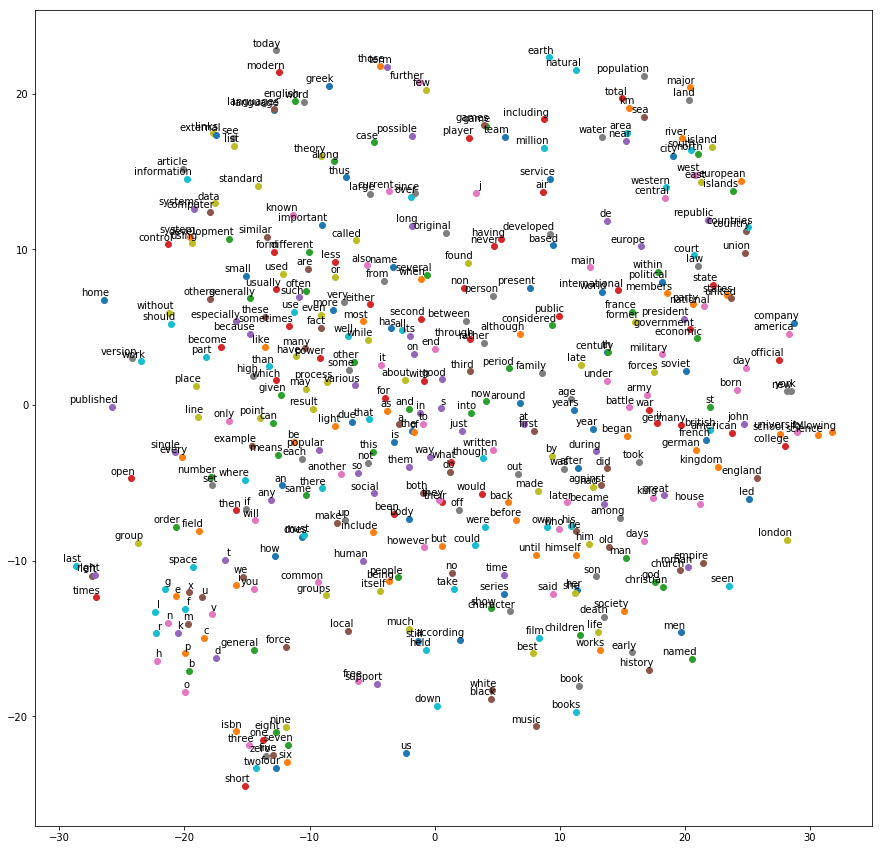

In [69]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)